# Import packages

In [467]:
import requests
import json
import pandas as pd
import numpy as np
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import pickle
import geopandas as gpd


from datetime import date, timedelta
import covidcast

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.impute import KNNImputer, SimpleImputer 
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, confusion_matrix, roc_auc_score, plot_confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


pd.set_option('display.max_columns', 100)

# Import Data

In [386]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv'
s = requests.get(url).text
nymask = pd.read_csv(StringIO(s))

In [387]:
nymask.COUNTYFP = nymask.COUNTYFP.astype(str)
nymask.COUNTYFP = np.where(nymask['COUNTYFP'].str.len() == 4, '0' + nymask.COUNTYFP, nymask.COUNTYFP)
nymask.COUNTYFP = nymask.COUNTYFP.astype(int)
nymask.columns = ['FIPS', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']

In [388]:
# create variable to hold date object for two days ago
two_days_ago = date.today() - timedelta(days=2)

In [389]:
# get the most recent survey data
mask_ind = covidcast.signal("fb-survey", "smoothed_wearing_mask",
                            date(2020, 10, 1), two_days_ago,
                            "county")
mask_oth = covidcast.signal('fb-survey', 'smoothed_others_masked', 
                            date(2020, 11, 24),two_days_ago, 
                            "county")

In [390]:
# remove data that isn't at the county level
mask_fip = mask_ind.loc[~mask_ind.geo_value.str.endswith('000')]
mask_oth = mask_oth.loc[~mask_oth.geo_value.str.endswith('000')]

In [391]:
# check number of counties represented 
print(mask_ind.geo_value.value_counts().shape)
print(mask_fip.geo_value.value_counts().shape)
mask_oth.geo_value.value_counts().shape

(726,)
(677,)


(655,)

In [392]:
# pare down datasets to just columns of interest
mask_ind_means = pd.DataFrame(mask_fip.groupby(['geo_value'])['value'].mean()).reset_index()
mask_ind_means.columns = ['FIPS', 'ind_mask']
mask_ind_means['FIPS'] = mask_ind_means['FIPS'].astype(int)
# repeat for other survey
mask_oth_means = pd.DataFrame(mask_oth.groupby(['geo_value'])['value'].mean()).reset_index()
mask_oth_means.columns = ['FIPS', 'oth_mask']
mask_oth_means['FIPS'] = mask_oth_means['FIPS'].astype(int)

In [393]:
mask_means = mask_ind_means.merge(mask_oth_means, on = 'FIPS', how = 'outer')
mask_w_nyt = mask_means.merge(nymask, on = 'FIPS', how = 'outer')

In [394]:
election = pd.read_csv('data/county_statistics.csv', index_col="Unnamed: 0")

In [395]:
election = election[election.county != 'Unassigned']
election['county'] = election['county'] + ', ' + election['state']
# election.drop(['state'], axis=1, inplace=True)

In [396]:
to_keep = ['county', 'total_votes16', 'total_votes20' , 'percentage20_Joe_Biden']
election = election.dropna(subset=['votes20_Joe_Biden'])

In [397]:
merge_elec = election[to_keep]

In [398]:
print(merge_elec.shape)
# election.columns

(4633, 4)


In [399]:
rural_urban = pd.read_excel('data/ru_code.xls')
fip_rur = rural_urban[['FIPS', 'RUCC_2013']]

In [400]:
geo = gpd.read_file('https://opendata.arcgis.com/datasets/4cb598ae041348fb92270f102a6783cb_0.geojson')

In [401]:
geo = geo[~geo.Countyname.str.contains("Out of")]
geo = geo[~geo.Countyname.str.contains("Unassigned")]
geo = geo[~geo.ST_Name.str.contains("Puerto Rico")]
geo.drop(geo.tail(7).index, inplace=True)
geo['FIPS'] = geo.FIPS.astype('int64')

In [402]:
# prelim feature engineering
geo['Staf_Bed_Perc'] = geo['Beds_Staff'] / geo['Beds_Licen']
geo['Aged_Perc'] = geo.AgedPop / geo.POP_ESTIMA
geo['Pov_Perc'] = geo.POVALL_201 / geo.POP_ESTIMA
geo['beds_per_capita'] = geo.Beds_ICU / geo.POP_ESTIMA
geo['pop_density'] = geo['TotalPop'] / geo['Shape__Area']
geo['county'] = geo['Countyname'] + ', ' + geo['ST_Abbr']
# drop unneeded columns
geo.drop(columns=['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 
                  'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 
                  'Day_11', 'Day_12', 'Day_13', 'Day_14', 
                  'OBJECTID', 'ST_ID', 'PCTPOVALL_', 'Med_HH_Inc', 
                  'State_Fata', 'DateChecke', 'url', 'Thumbnail', 
                  'State_Conf', 'State_Deat', 'State_Reco', 'State_Test', 
                  'POP_ESTIMA', 'BlackPop', 'AmIndop', 'PacIslPop', 
                  'OtherPop', 'TwoMorPop', 'HispPop', 'NonHisp', 
                  'Agetotal', 'AsianPop', 'Countyname', 'ST_Name',
                  'Confirmed', 'Deaths', 'Unemployed', 'Beds_Licen', 
                  'Beds_Staff', 'Ventilator', 'Unemployed', 'Beds_ICU', 'AgedPop',
                  'Wh_Alone', 'Bk_Alone', 'AI_Alone', 'As_Alone', 'NH_Alone', 'SO_Alone', 
                  'Two_More', 'Not_Hisp', 'Age_Over75'], 
            inplace=True)

In [403]:
geo.drop(columns=['Recovered', 'Active'], inplace=True)
geo.drop(columns=['EM_notes'], inplace=True)
geo.EM_date = geo.EM_date.str.extract(r'((\d+)\/(\d{2})\/(\d{4}))')
geo.EM_type = geo.EM_type.replace({'Govt Ordered Community Quarantine': 'CQ', 'Govt Directed Social Distancing': 'SD'})

In [404]:
fip_rur.shape

(3234, 2)

In [405]:
geo = geo.merge(fip_rur, how = 'left', on = 'FIPS')

In [406]:
merge1 = geo.merge(mask_w_nyt, how = 'left', on = 'FIPS')

In [407]:
merge1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 44 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ST_Abbr          3142 non-null   object  
 1   FIPS             3142 non-null   int64   
 2   FatalityRa       3142 non-null   float64 
 3   Confirmedb       3142 non-null   float64 
 4   DeathsbyPo       3142 non-null   float64 
 5   Unemployme       3142 non-null   float64 
 6   EM_type          3142 non-null   object  
 7   EM_date          2515 non-null   object  
 8   Age_85           3142 non-null   int64   
 9   Age_80_84        3142 non-null   int64   
 10  Age_75_79        3142 non-null   int64   
 11  Age_70_74        3142 non-null   int64   
 12  Age_65_69        3142 non-null   int64   
 13  POVALL_201       3142 non-null   int64   
 14  Median_Hou       3142 non-null   int64   
 15  NewCases         3142 non-null   int64   
 16  NewDeaths        3142 non-null   i

## Impute
The following code block was an attempt to impute missing mask data for us to build a model for all counties. This proved ineffective and has been commented out.

In [408]:
# impute_df = merge1[['TotalPop', 'Median_Hou', 'RUCC_2013', 'ind_mask', 'oth_mask']]
# impute_df['RUCC_2013'].astype(str)

# scaler = StandardScaler()
# impute_df = pd.DataFrame(scaler.fit_transform(impute_df), columns = impute_df.columns)

# knn_imputer = KNNImputer(n_neighbors=4, weights = 'distance')

# imputed = knn_imputer.fit_transform(impute_df)

# mask_imputed = pd.DataFrame(imputed, columns = impute_df.columns)['ind_mask']

# merge1['ind_mask'] = mask_imputed

# Prepare merged datasets for modeling

In [409]:
elec_geo_df = merge1.merge(merge_elec, on = 'county',how='left', sort=True)

In [410]:
elec_geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ST_Abbr                 3142 non-null   object  
 1   FIPS                    3142 non-null   int64   
 2   FatalityRa              3142 non-null   float64 
 3   Confirmedb              3142 non-null   float64 
 4   DeathsbyPo              3142 non-null   float64 
 5   Unemployme              3142 non-null   float64 
 6   EM_type                 3142 non-null   object  
 7   EM_date                 2515 non-null   object  
 8   Age_85                  3142 non-null   int64   
 9   Age_80_84               3142 non-null   int64   
 10  Age_75_79               3142 non-null   int64   
 11  Age_70_74               3142 non-null   int64   
 12  Age_65_69               3142 non-null   int64   
 13  POVALL_201              3142 non-null   int64   
 14  Median_Hou      

In [411]:
condition = [(elec_geo_df['percentage20_Joe_Biden']) <= .25, 
             (elec_geo_df['percentage20_Joe_Biden'] > .25) & (elec_geo_df['percentage20_Joe_Biden'] <= .50),
             (elec_geo_df['percentage20_Joe_Biden'] > .50) & (elec_geo_df['percentage20_Joe_Biden'] <= .75),
             (elec_geo_df['percentage20_Joe_Biden']) > .75]
choices = [0,1,2,3]

elec_geo_df['percentage20_Joe_Biden'] = np.select(condition, choices, elec_geo_df['percentage20_Joe_Biden'])

In [412]:
elec_geo_df.shape

(3142, 47)

In [413]:
base_feat = ['TotalPop', 'total_votes16','Median_Hou', 'Unemployme','RUCC_2013', 'NonHispWhP',
            'Age_Less15', 'Age_15_24', 'Age_25_34', 'Age_35_64', 'Age_65_74',
             'Age_85', 'Age_80_84', 'Age_75_79', 'Age_70_74', 'Age_65_69']

features = base_feat + ['ind_mask', 'oth_mask']

In [414]:
len(features)

18

In [415]:
elec_geo_df.dropna(subset=features, inplace=True)

In [416]:
elec_geo_df.shape

(627, 47)

# Modeling Process
_Here we will check to see if including data on mask compliance gives us increased modeling performance_

In [496]:
X_base = elec_geo_df[base_feat]
X_mask = elec_geo_df[features]

y = elec_geo_df['percentage20_Joe_Biden']

In [422]:
# train/test split data for baseline dataset and the dataset with mask features 
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y, random_state = 9)
# with mask data
X_train_mask, X_test_mask, y_train_mask, y_test_mask = train_test_split(X_mask, y, random_state = 9)

In [469]:
# use oversampling to help with class imablance for training data
smote_base = SMOTE()
X_train_base, y_train_base = smote_base.fit_sample(X_train_base, y_train_base)
# oversample mask data
smote_mask = SMOTE()
X_train_mask, y_train_mask = smote_mask.fit_sample(X_train_mask, y_train_mask)

In [ ]:
# define function to evaluate the models
def get_scores(model, X, y, name):
    #get predictions
    y_pred = model.predict(X)
   
    # ROC/AUC for multi-class 
    y_bin = label_binarize(y, classes = [0,1,2,3])
    plot_confusion_matrix(model,X, y)
    plt.title(name)
    plt.show()
    
    f1 = f1_score(y, y_pred, average='weighted')
    acc = accuracy_score(y, y_pred)
    roc = roc_auc_score(y_bin, model.predict_proba(X), multi_class='ovr', average='weighted')
    return print(f'Accuracy Score: {round(acc,3)} \n F1 Score: {round(f1, 3)} \n ROC AUC: {round(roc,3)}')

## Random Forest Classifier

In [471]:
# prepare gridsearch parameter grid
grid = [{'RF__max_depth': [4,5,6],
        'RF__min_samples_split': [2,5,10],
        'RF__criterion': ['entropy', 'gini'],
        'RF__min_samples_leaf': [1,3,5]}]

In [472]:
# instantiate and fit gridsearch for baseline data
gridsearch_base = GridSearchCV(estimator = pipeline_base, param_grid=grid, scoring='accuracy', cv = 5)
gridsearch_base.fit(X_train_base, y_train_base)

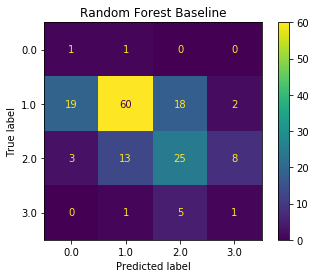

Accuracy Score: 0.554 
 F1 Score: 0.602 
 ROC AUC: 0.756


In [548]:
# check performance
get_scores(gridsearch_base, X_test_base, y_test_base, 'Random Forest Baseline')

### Random Forest with Mask Features

In [475]:
# Instantiate and gridsearch model for masked data
gridsearch_mask = GridSearchCV(estimator = pipeline_mask, param_grid=grid, scoring='accuracy', cv = 5)
gridsearch_mask.fit(X_train_mask, y_train_mask)

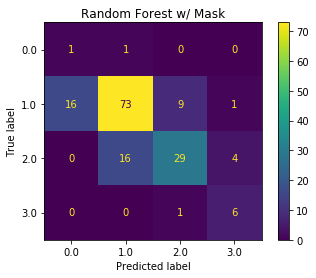

Accuracy Score: 0.694 
 F1 Score: 0.724 
 ROC AUC: 0.851


In [549]:
#check performance
get_scores(gridsearch_mask, X_test_mask, y_test_mask, 'Random Forest w/ Mask')

#### _Data with Mask features resulted in about a 10% increase in performance_

## XGBoost Classifier

In [478]:
# instantiate pipelines
xg_pipe_base = Pipeline([('ss', StandardScaler()), ('XG', XGBClassifier(random_state=46))])
xg_pipe_mask = Pipeline([('ss', StandardScaler()), ('XG', XGBClassifier(random_state=46))])

In [479]:
# prepare gridsearch parameter grid
param_grid = {
    'XG__learning_rate': [0.05, 0.1, 0.2],
    'XG__max_depth': [4, 5, 6, 10],
    'XG__min_child_weight': [1, 2, 5,7],
    'XG__subsample': [0.5, 0.7],
    'XG__n_estimators': [100],
}

In [480]:
# instantiate and fit gridsearch for baseline data
grid_xg_base = GridSearchCV(estimator = xg_pipe_base, param_grid=param_grid, scoring = 'accuracy', cv= 3)
grid_xg_base.fit(X_train_base, y_train_base)

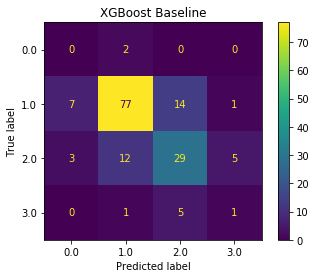

Accuracy Score: 0.682 
 F1 Score: 0.701 
 ROC AUC: 0.806


In [551]:
# check performance
get_scores(grid_xg_base, X_test_base, y_test_base, 'XGBoost Baseline')

### XGBoost with Mask Features

In [483]:
# instantiate and fit gridsearch for mask data
grid_xg_mask = GridSearchCV(estimator = xg_pipe_mask, param_grid=param_grid, scoring = 'accuracy', cv= 3)
grid_xg_mask.fit(X_train_mask, y_train_mask)

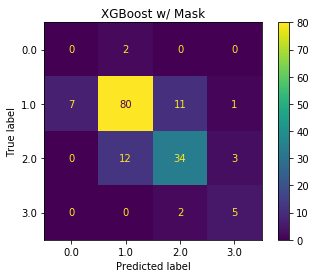

Accuracy Score: 0.758 
 F1 Score: 0.772 
 ROC AUC: 0.891


In [552]:
# check performance
get_scores(grid_xg_mask, X_test_mask, y_test_mask, 'XGBoost w/ Mask')

#### _Masked features had a difference of more than 7% for all three indicators_

## Logistic Regression Classifier

In [484]:

grid_xg_mask.score(X_test_mask, y_test_mask)

0.7579617834394905

In [553]:
# instantiate pipelines
lr_pipe_base = Pipeline([('ss', StandardScaler()), ('LR', LogisticRegression(random_state=46, solver = 'liblinear', C= 1e12))])
lr_pipe_mask = Pipeline([('ss', StandardScaler()), ('LR', LogisticRegression(random_state=46, solver = 'liblinear', C= 1e12))])

In [557]:
# fit baseline data to model
lr_pipe_base.fit(X_train_base, y_train_base);

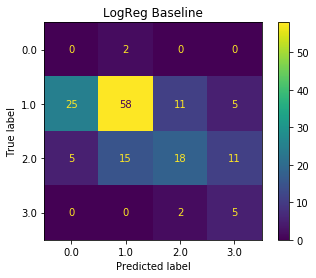

Accuracy Score: 0.516 
 F1 Score: 0.577 
 ROC AUC: 0.756


In [558]:
get_scores(lr_pipe_base, X_test_base, y_test_base, 'LogReg Baseline')

### Logistic Regression with mask features

In [560]:
# fit model
lr_pipe_mask.fit(X_train_mask, y_train_mask);

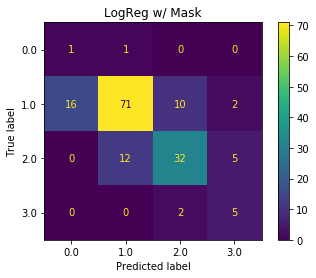

Accuracy Score: 0.694 
 F1 Score: 0.729 
 ROC AUC: 0.824


In [561]:
# check performance
get_scores(lr_pipe_mask, X_test_mask, y_test_mask, 'LogReg w/ Mask')

#### _score was improved by more than 7% on all indicators_